In [7]:
# Importing Libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

In [8]:
# Defining a function for loading the image

def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a
                                               #batch of single image

    return im_array

In [9]:
# Function for plotting the Image
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

In [11]:
content_path = '/content/images (2).jpg'
style_path ='/content/styleimage.jpg'
content = load_file(content_path)
style = load_file(style_path)

<ipython-input-8-e495842550cf>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


<ipython-input-8-e495842550cf>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


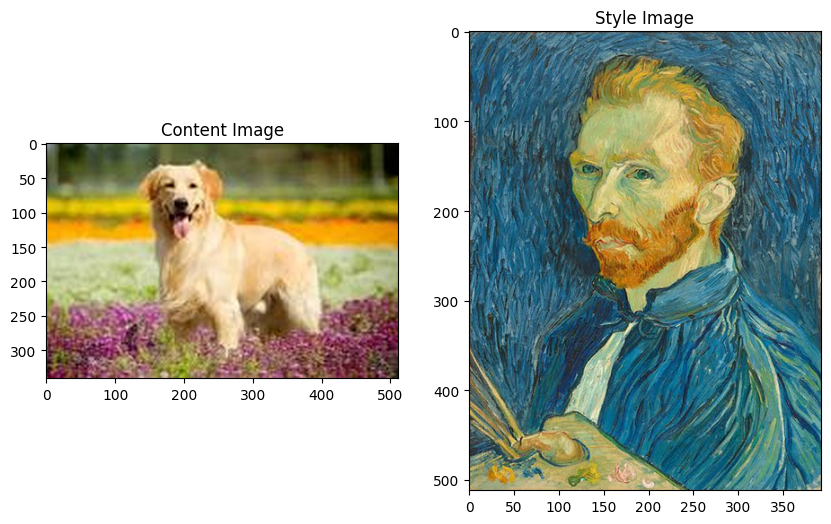

In [12]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [13]:
# Preprocessing Image for VGG 19
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [14]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]


  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [15]:
im=img_preprocess(content_path)

<ipython-input-8-e495842550cf>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)


In [18]:
# Defining Layers for aquring features from Style and Content Image
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

In [19]:
# Defining Model
def get_model():

    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [20]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [21]:
model=get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


In [23]:
# Now, we will be defining loss functions for both content and style images

# For Content Loss
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

# For Style Loss
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

In [24]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [25]:
# for acquiring features form model for style and content images
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)

    content_output=model(content_img)
    style_output=model(style_image)

    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

In [26]:
# Now, Total loss is defined as Loss for style image + loss for content image
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image

    output=model(image)
    content_loss=0
    style_loss=0

    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]

    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)


    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)

    style_loss *= style_weight
    content_loss *= content_weight

    total_loss = content_loss + style_loss


    return total_loss,style_loss,content_loss

In [27]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)

    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [28]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

In [29]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [30]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):

    model=get_model()

    for layer in model.layers:
        layer.trainable = False

    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]

    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss,best_img=float('inf'),None

    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)

        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())

         #for visualization

        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))
            print('Total loss: {:.4e}, '
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))

    IPython.display.clear_output(wait=True)


    return best_img,best_loss,imgs

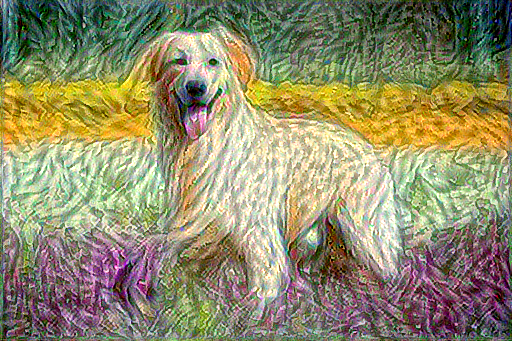

Epoch: 45
Total loss: 1.0894e+07, style loss: 8.9825e+06, content loss: 1.9114e+06, 


In [32]:
best, best_loss,image = run_style_transfer(content_path, style_path, epochs=50)

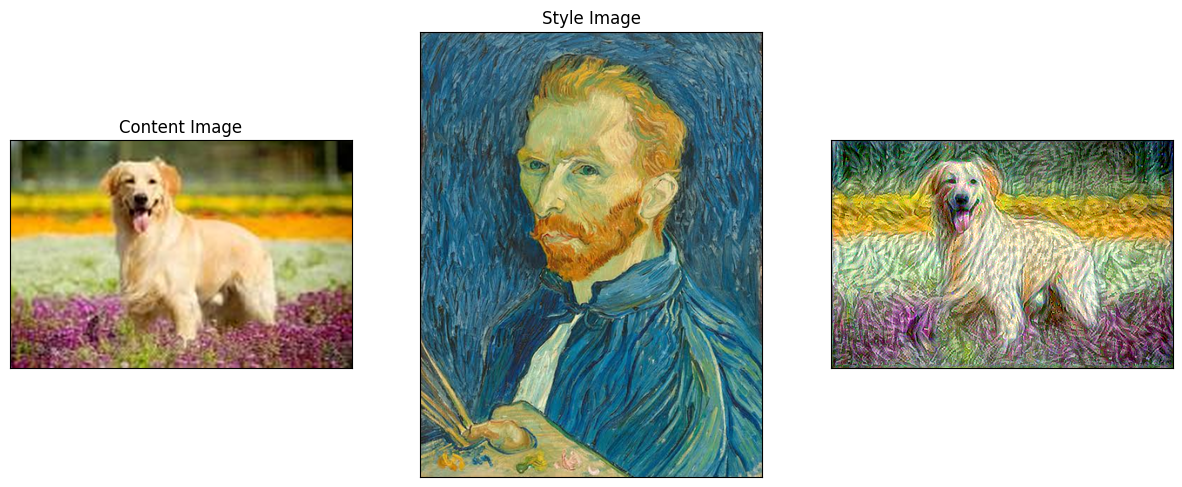

In [33]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# Limitations for using

# Limitations of my model

# Content loss: VGG-19 is primarily designed for image classification, and its feature activations are not well-suited for capturing the fine-grained details of an image's content. This can lead to stylized images that lose some of the sharpness and clarity of the original content image.

# Style loss: The style loss used in neural style transfer with VGG-19 is based on the Gram matrix, which captures the pairwise correlations between feature activations. This can produce stylized images that are overly stylized or that do not accurately capture the style of the style image.

# Computational cost: VGG-19 is a large and complex network, and its use in neural style transfer can be computationally expensive. This can make it difficult to use neural style transfer with VGG-19 in real-time applications.

# Potential Improvements for VGG-19 Neural Style Transfer

# Using a different content loss function: There are a number of different content loss functions that can be used for neural style transfer. Some of these loss functions are better at capturing the fine-grained details of an image's content, which can lead to stylized images that are more faithful to the original content image.

# Using a different style loss function: There are a number of different style loss functions that can be used for neural style transfer. Some of these loss functions are better at capturing the style of a style image, which can lead to stylized images that are more accurate and less stylized.

# Using a more efficient network: There are a number of different CNN architectures that are more efficient than VGG-19. These networks can be used for neural style transfer with less computational cost, which can make it possible to use neural style transfer in real-time applications.